In [ ]:
# -*- coding: utf-8 -*-
"""Untitled6.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1WGylAK8f3xbgZ6SopiVWjPhzwNUataVz
"""

import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#loading the file
file_path = '/content/drive/MyDrive/umist_cropped.mat'  # Path to the uploaded file
data = scipy.io.loadmat(file_path)

# extracting image data and labels
facedat = data['facedat']  # Image data for each class
dirnames = data['dirnames']  # Class identifiers

# Flatten the dataset into a usable format
images = []  # To store flattened images
labels = []  # To store corresponding class labels

# Looping through each class in facedat and extract the images
for class_index, class_data in enumerate(facedat[0]):
    num_images = class_data.shape[-1]  # Number of images in the class
    for i in range(num_images):
        images.append(class_data[:, :, i].flatten())  # Flatten each image
        labels.append(class_index)  # Assign the class index as the label

# converting lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Dataset loaded: {images.shape[0]} samples, each with {images.shape[1]} features.")
print(f"Number of classes: {len(np.unique(labels))}")

# Dataset Splitting
# Split the data into training, validation, and test sets with stratified sampling
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
)  # 0.1765 ensures ~15% validation

print("Dataset Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#Data Preprocessing
# Normalize pixel values to [0, 1]
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Standardize to zero mean and unit variance
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_norm)
X_val_std = scaler.transform(X_val_norm)
X_test_std = scaler.transform(X_test_norm)

print(f"Training set mean (after standardization): {X_train_std.mean():.4f}")
print(f"Training set std deviation (after standardization): {X_train_std.std():.4f}")

# Dimensionality Reduction with PCA
# Retain 99% variance
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train_std)  # Fit and transform training data
X_val_pca = pca.transform(X_val_std)          # Apply PCA transformation to validation data
X_test_pca = pca.transform(X_test_std)        # Apply PCA transformation to test data

print("PCA Transformation:")
print(f"Original feature dimension: {X_train.shape[1]}")
print(f"Reduced feature dimension: {X_train_pca.shape[1]}")
print(f"Explained Variance Ratio (PCA): {pca.explained_variance_ratio_.sum():.4f}")

Dataset loaded: 575 samples, each with 10304 features.
Number of classes: 20
Dataset Split:
Training set: 401 samples
Validation set: 87 samples
Test set: 87 samples
Training set mean (after standardization): -0.0000
Training set std deviation (after standardization): 1.0000
PCA Transformation:
Original feature dimension: 10304
Reduced feature dimension: 248
Explained Variance Ratio (PCA): 0.9901


Agglomerative Hierarchical Clustering Evaluation:
Adjusted Rand Index (ARI): 0.3742
Normalized Mutual Information (NMI): 0.7452
Silhouette Score: 0.2113


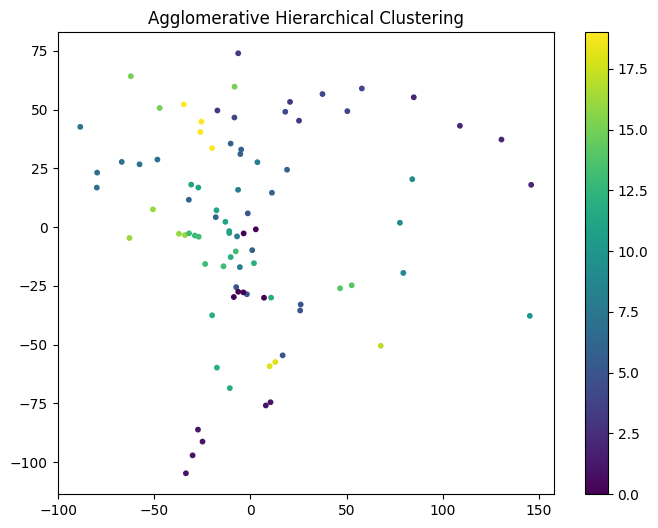

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Number of clusters based on the number of classes
n_clusters = len(np.unique(labels))

# Apply Agglomerative Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(X_test_pca)

# Evaluate Agglomerative Clustering
agglo_ari = adjusted_rand_score(y_test, agglo_labels)
agglo_nmi = normalized_mutual_info_score(y_test, agglo_labels)
agglo_silhouette = silhouette_score(X_test_pca, agglo_labels)

print("Agglomerative Hierarchical Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {agglo_ari:.4f}")
print(f"Normalized Mutual Information (NMI): {agglo_nmi:.4f}")
print(f"Silhouette Score: {agglo_silhouette:.4f}")

# Visualization
# Reduce data to 2D for visualization
pca_2d = PCA(n_components=2)
X_test_2d = pca_2d.fit_transform(X_test_pca)

# Plot Agglomerative Clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=agglo_labels, cmap='viridis', s=10)
plt.title("Agglomerative Hierarchical Clustering")
plt.colorbar()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding for multi-class classification
num_classes = len(np.unique(labels))
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Define the dense neural network model
model = Sequential([
    Dense(256, input_dim=X_train_pca.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_pca, y_train_onehot,
    validation_data=(X_val_pca, y_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pca, y_test_onehot, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.0516 - loss: 14.1957 - val_accuracy: 0.0920 - val_loss: 3.1434
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0773 - loss: 8.6693 - val_accuracy: 0.2069 - val_loss: 2.6376
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0787 - loss: 5.8303 - val_accuracy: 0.2644 - val_loss: 2.4938
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0871 - loss: 4.9880 - val_accuracy: 0.3678 - val_loss: 2.4807
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0973 - loss: 4.3610 - val_accuracy: 0.4023 - val_loss: 2.5106
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1343 - loss: 3.6521 - val_accuracy: 0.3908 - val_loss: 2.5115
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1280 - loss: 3.4415 - val_accuracy: 0.4138 - val_loss: 2.5176
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1043 - loss: 3.6208 - val_accuracy: 

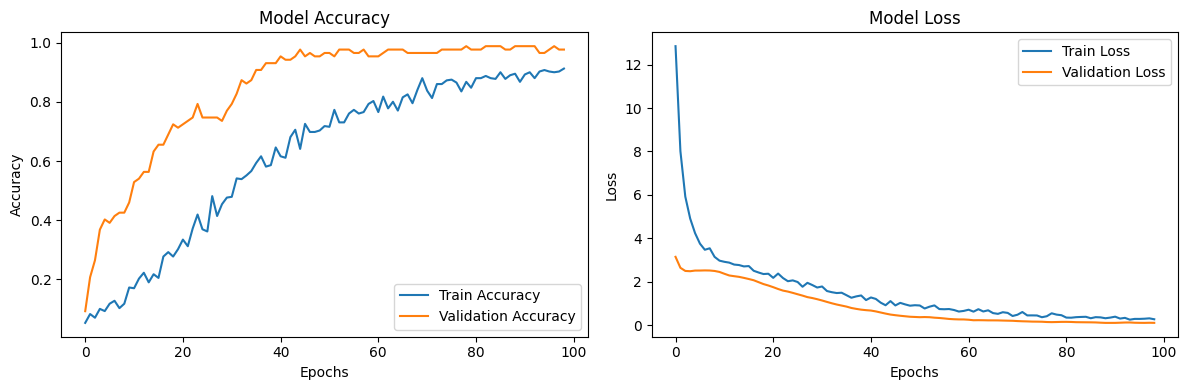

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Predicted labels: [13  7  3  9 12 18 13  6 17  2]
True labels:      [13  7  3  9 12 18 13  6 17  2]


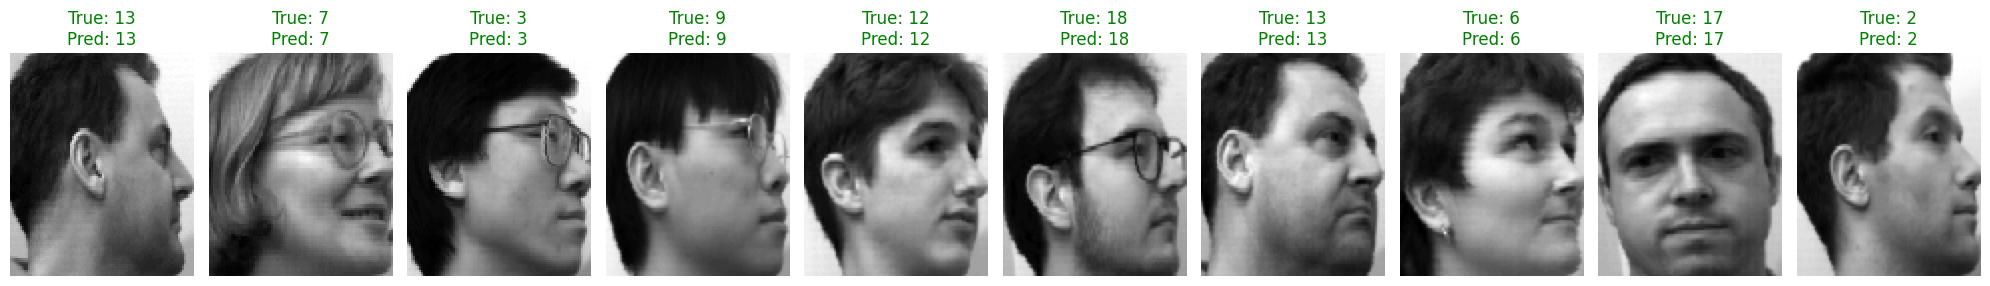

In [ ]:
# Predict class probabilities
y_pred_probs = model.predict(X_test_pca)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Example: Display predictions for the first 10 samples
print("Predicted labels:", y_pred_classes[:10])
print("True labels:     ", y_test[:10])

# Verify the predictions with images
import matplotlib.pyplot as plt


# Plot the first 10 test images with predictions and true labels
num_samples_to_plot = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(20, 5))

for i in range(num_samples_to_plot):
    ax = axes[i]
    ax.imshow(X_test[i].reshape(112, 92), cmap='gray')  # Assuming the original images are 112x92 pixels
    ax.axis('off')
    ax.set_title(
        f"True: {y_test[i]}\nPred: {y_pred_classes[i]}",
        color="green" if y_test[i] == y_pred_classes[i] else "red"
    )

plt.tight_layout()
plt.show()



In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          63,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318,590 (1.22 MB)

 Trainable params: 106,196 (414.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 212,394 (829.67 KB)